# SET ENVIRONMENT

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sea
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import models
import torchvision
from sklearn.metrics import precision_score, recall_score, f1_score

import os
from google.colab import files


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# PREPROCESS DATA

In [ ]:
# Creazione manuale del file kaggle.json
kaggle_json = '''{
    "username":"alessiodeluca12",
    "key":"53d564efd9267f435292052d6b8b3cdc"
}'''

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as file:
    file.write(kaggle_json)
os.chmod('/root/.kaggle/kaggle.json', 600)

# 2. Scarica il dataset da Kaggle
!pip install -q kaggle
!kaggle datasets download -d swoyam2609/fresh-and-stale-classification
!unzip -q fresh-and-stale-classification.zip -d /content/data

# 3. Percorsi dei dati
TRAIN_PATH = '/content/data/dataset/Train'
TEST_PATH = '/content/data/dataset/Test'

# 4. Import delle librerie necessarie
import os
import pandas as pd
from tqdm import tqdm

# 5. Funzione per caricare i dati
def load_data(PATH):
    filenames, fruit, fresh = [], [], []

    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6:])
            filenames.append(os.path.join(PATH, file, img))

    df = pd.DataFrame({
        'filename': filenames,
        'fruit': fruit,
        'fresh': fresh
    })

    return df

# 6. Caricamento dei dati di train e test
df_train = load_data(TRAIN_PATH).sample(frac=1)
df_test = load_data(TEST_PATH).sample(frac=1)

# 7. Verifica delle dimensioni dei dataset
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)


Dataset URL: https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification
License(s): Community Data License Agreement - Permissive - Version 1.0
100% 2.84G/2.84G [00:43<00:00, 67.6MB/s]
100% 2.84G/2.84G [00:43<00:00, 70.4MB/s]


100%|██████████| 14/14 [00:00<00:00, 836.19it/s]

Train shape: (23619, 3)
Test shape: (6738, 3)


In [ ]:
df_test['fruit'] = df_test['fruit'].map(lambda x : 'tomato' if x == 'tamto' else x)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'potato' if x == 'patato' else x)
df_train['fruit'] = df_train['fruit'].map(lambda x : 'bittergourd' if x == 'bittergroud' else x)

In [ ]:
df_train['fruit'].unique()

array(['apples', 'tomato', 'capsicum', 'potato', 'banana', 'cucumber',
       'oranges', 'bittergourd', 'okra'], dtype=object)

<Axes: xlabel='fruit', ylabel='count'>

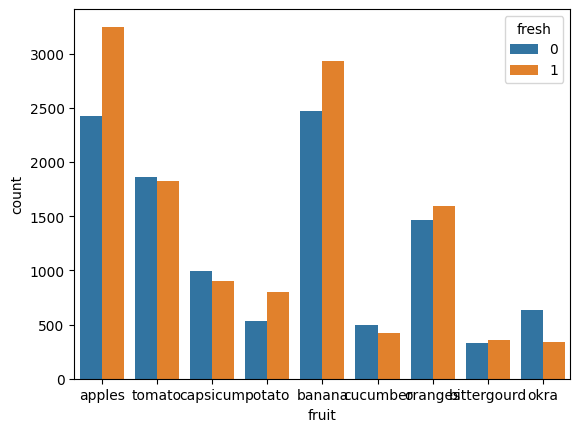

In [ ]:
sea.countplot(x = 'fruit', data = df_train, hue = 'fresh')

<Axes: xlabel='fruit', ylabel='count'>

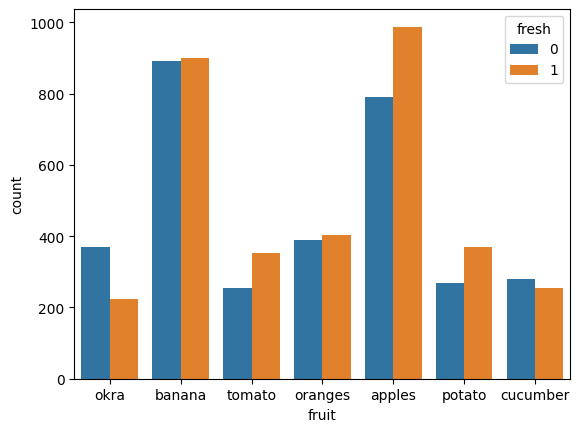

In [ ]:
sea.countplot(x = 'fruit', data = df_test, hue = 'fresh')

In [ ]:
# Filtra le righe della categoria 'capsicum' da df_train
capsicum_rows = df_train[df_train['fruit'] == 'capsicum']

# Determina il numero di righe da spostare
num_to_move = int(len(capsicum_rows) * 0.3)

# Seleziona casualmente il 30% delle righe di capsicum
capsicum_to_test = capsicum_rows.sample(n=num_to_move, random_state=42)

# Aggiungi le righe selezionate al test set
df_test = pd.concat([df_test, capsicum_to_test])

# Rimuovi le righe spostate dal train set
df_train = df_train.drop(capsicum_to_test.index)

# Verifica finale
print("Forma finale di df_train:", df_train.shape)
print("Forma finale di df_test:", df_test.shape)
print("Conteggio 'capsicum' in df_train:", len(df_train[df_train['fruit'] == 'capsicum']))
print("Conteggio 'capsicum' in df_test:", len(df_test[df_test['fruit'] == 'capsicum']))

Forma finale di df_train: (23052, 3)
Forma finale di df_test: (7305, 3)
Conteggio 'capsicum' in df_train: 1324
Conteggio 'capsicum' in df_test: 567


In [ ]:
# Filtra le righe della categoria 'capsicum' da df_train
bittergourd_rows = df_train[df_train['fruit'] == 'bittergourd']

# Determina il numero di righe da spostare
num_to_move = int(len(bittergourd_rows) * 0.3)

# Seleziona casualmente il 30% delle righe di capsicum
bittergourd_to_test = bittergourd_rows.sample(n=num_to_move, random_state=42)

# Aggiungi le righe selezionate al test set
df_test = pd.concat([df_test, bittergourd_to_test])

# Rimuovi le righe spostate dal train set
df_train = df_train.drop(bittergourd_to_test.index)

# Verifica finale
print("Forma finale di df_train:", df_train.shape)
print("Forma finale di df_test:", df_test.shape)
print("Conteggio 'bittergourd' in df_train:", len(df_train[df_train['fruit'] == 'bittergourd']))
print("Conteggio 'bittergourd' in df_test:", len(df_test[df_test['fruit'] == 'bittergourd']))

Forma finale di df_train: (22847, 3)
Forma finale di df_test: (7510, 3)
Conteggio 'bittergourd' in df_train: 479
Conteggio 'bittergourd' in df_test: 205


<Axes: xlabel='fruit', ylabel='count'>

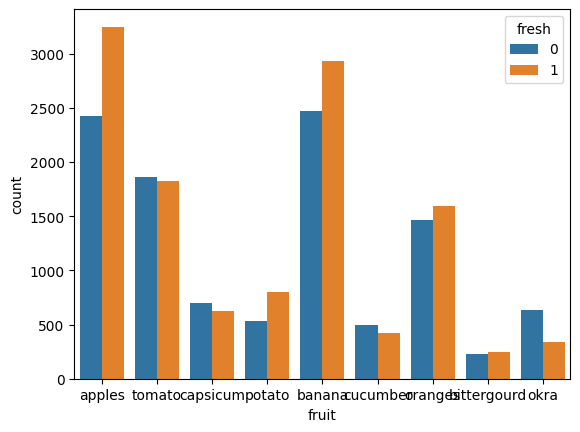

In [ ]:
sea.countplot(x = 'fruit', data = df_train, hue = 'fresh')

<Axes: xlabel='fruit', ylabel='count'>

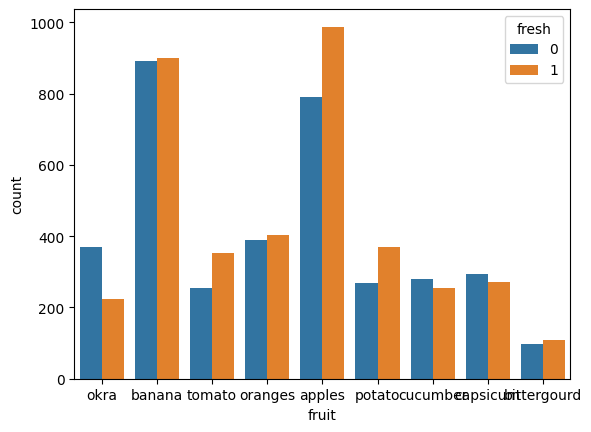

In [ ]:
sea.countplot(x = 'fruit', data = df_test, hue = 'fresh')

In [ ]:
print(df_train['fruit'].value_counts().sum())

22847


In [ ]:
counts = df_train['fruit'].value_counts()
df_train_new = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])

for (key, value) in counts.items():
    if value > 1000:
        df_temp = df_train[df_train['fruit'] == key].sample(n = 1000)
    else:
        df_temp = df_train[df_train['fruit'] == key]

    df_train_new = pd.concat([df_train_new, df_temp], axis = 0)

df_train_new.shape

(8369, 3)

<Axes: xlabel='fruit', ylabel='count'>

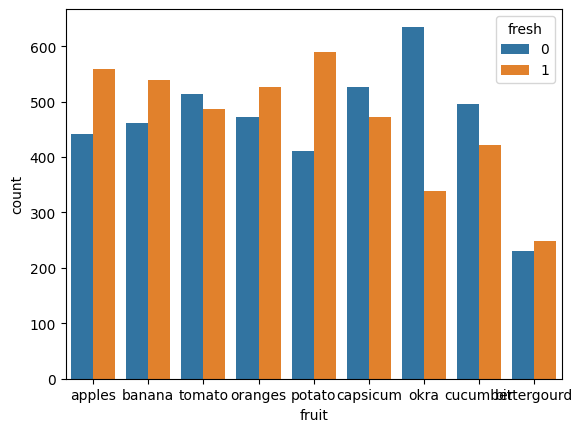

In [ ]:
sea.countplot(x = 'fruit', data = df_train_new, hue = 'fresh')

In [ ]:
counts = df_test['fruit'].value_counts()
df_test_new = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])

for (key, value) in counts.items():
    if value > 600:
        df_temp = df_test[df_test['fruit'] == key].sample(n = 600)
    else:
        df_temp = df_test[df_test['fruit'] == key]

    df_test_new = pd.concat([df_test_new, df_temp], axis = 0)

df_test_new.shape

(4900, 3)

<Axes: xlabel='fruit', ylabel='count'>

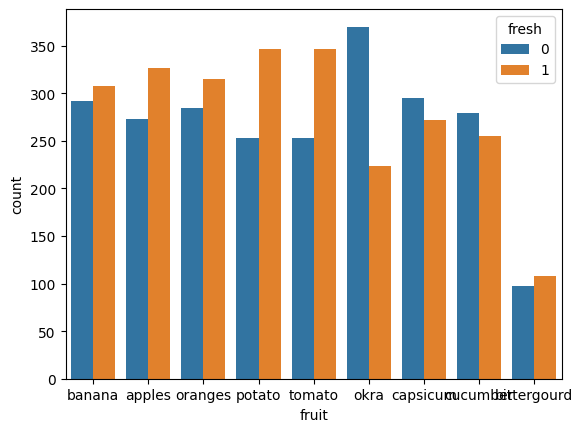

In [ ]:
sea.countplot(x = 'fruit', data = df_test_new, hue = 'fresh')

In [ ]:
le = LabelEncoder()

df_train_new['fruit_label'] = le.fit_transform(df_train_new['fruit'])
df_train_new.shape

(8369, 4)

In [ ]:
le = LabelEncoder()

df_test_new['fruit_label'] = le.fit_transform(df_test_new['fruit'])
df_test_new.shape

(4900, 4)

In [ ]:
df_train_new.head()

filename   fruit fresh  \
2456  /content/data/dataset/Train/rottenapples/salta...  apples     1   
2344  /content/data/dataset/Train/rottenapples/a_r39...  apples     1   
5034  /content/data/dataset/Train/freshapples/saltan...  apples     0   
1978  /content/data/dataset/Train/rottenapples/verti...  apples     1   
921   /content/data/dataset/Train/rottenapples/rotat...  apples     1   

      fruit_label  
2456            0  
2344            0  
5034            0  
1978            0  
921             0

In [ ]:
# Dizionario per associare le etichette numeriche alle categorie originali
label_to_fruit = {index: label for index, label in enumerate(le.classes_)}

print(label_to_fruit)


{0: 'apples', 1: 'banana', 2: 'bittergourd', 3: 'capsicum', 4: 'cucumber', 5: 'okra', 6: 'oranges', 7: 'potato', 8: 'tomato'}


**Train-Val-Test Split and Visualization**

In [ ]:
df_train_new, df_val_new = train_test_split(df_train_new, test_size = 0.20, stratify = df_train_new['fruit'])

df_train_new.shape, df_val_new.shape

((6695, 4), (1674, 4))

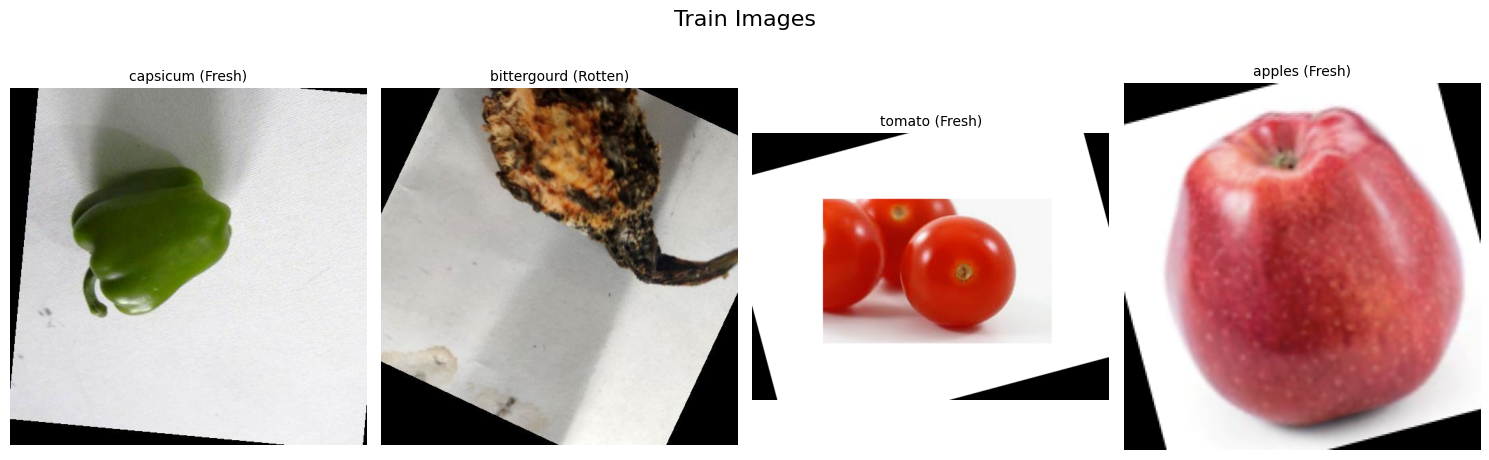

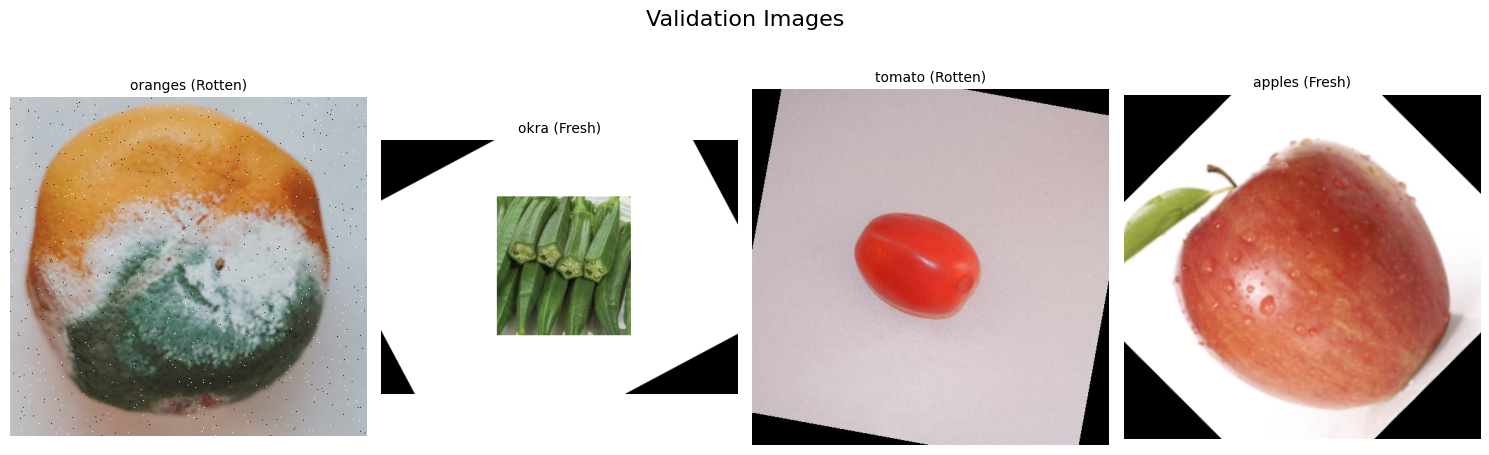

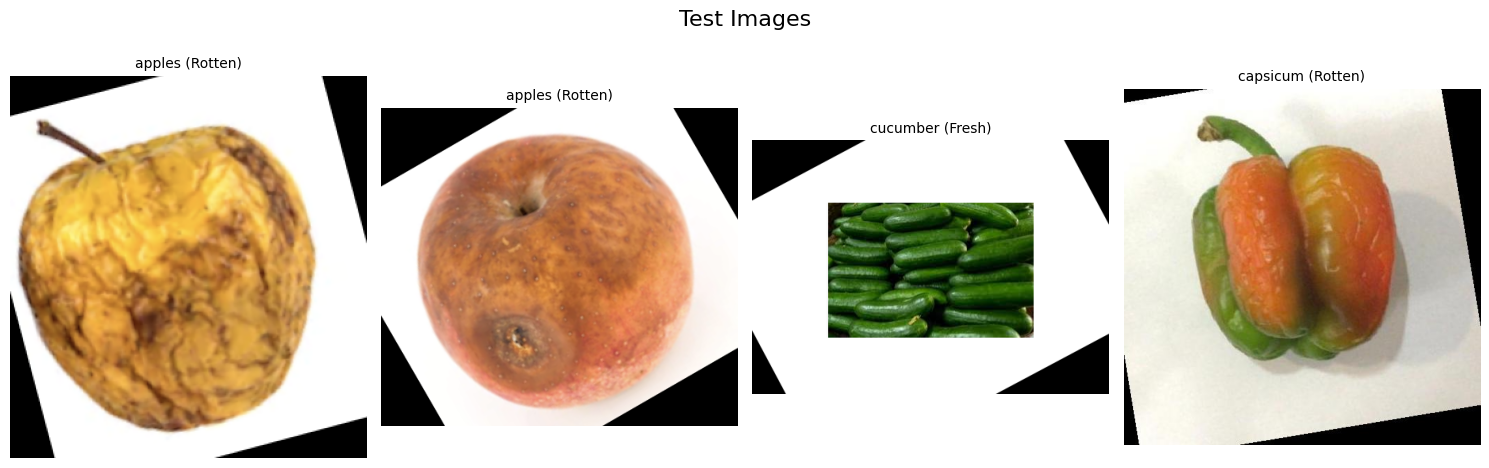

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Funzione per mostrare immagini a random con etichette e freschezza
def plot_images_with_labels(df, title, num_images=4):
    # Seleziona a caso le righe dal DataFrame
    sampled_df = df.sample(n=num_images, random_state=random.randint(0, 100))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        try:
            # Leggi il percorso dell'immagine e le etichette
            img_path = sampled_df.iloc[i]['filename']
            fruit = sampled_df.iloc[i]['fruit']
            fresh = sampled_df.iloc[i]['fresh']
            label = "Fresh" if fresh == 0 else "Rotten"

            # Carica l'immagine
            img = Image.open(img_path)

            # Mostra l'immagine
            ax.imshow(img)
            ax.set_title(f"{fruit} ({label})", fontsize=10)
            ax.axis('off')
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine: {e}")

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Mostra 4 immagini per train, validation e test con freschezza
plot_images_with_labels(df_train_new, "Train Images")
plot_images_with_labels(df_val_new, "Validation Images")
plot_images_with_labels(df_test, "Test Images")


eventualmente fare albumentation su bittergourd, le immagini sono gia augmentate ma potremmo farlo su quello giusto per permettere alla rete di imparare meglio quella immagine li variando ogni volta come la vede, valutiamo poi se farla su tutto il train, sempre tirare giù i risultati per fare confronti sulla effettiva utilità di un processo che implementiamo!!!

In [ ]:
def image_transform(training=True):
    if training:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=0.0, std=1.0),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=0.0, std=1.0),
            ToTensorV2()
        ])

# Dataset aggiornato
class FruitDataset:
    def __init__(self, df, training):
        self.df = df
        self.n_samples = len(self.df)
        self.training = training
        self.transform = image_transform(training=training)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Carica l'immagine
        img = plt.imread(self.df.iloc[idx]['filename'])[:, :, :3]

        # Recupera le etichette
        fresh = torch.tensor(self.df.iloc[idx]['fresh'])
        fruit = torch.tensor(self.df.iloc[idx]['fruit_label'])

        # Applica le trasformazioni
        augmented = self.transform(image=img)
        img = augmented['image']

        return img, fruit, fresh


In [ ]:
BATCH_SIZE = 64


train_dataset = FruitDataset(df_train_new, training = True)
val_dataset = FruitDataset(df_val_new, training = False)
test_dataset = FruitDataset(df_test_new, training = False)


train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = 16) #controllare il batch size eventualmente

# SIMPLE MODEL

In [ ]:
class DualTaskCNN(nn.Module):
    def __init__(self, num_classes_fruit, num_classes_fresh):
        super(DualTaskCNN, self).__init__()
        # Feature extractor - ridotto numero di canali
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.1)

        # Additional pooling layer to reduce spatial dimensions
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))

        # Fully connected layers (shared) - ridotte dimensioni
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 64)

        # Separate branches - invariate
        self.fc_fruit = nn.Linear(64, num_classes_fruit)
        self.fc_fresh = nn.Linear(64, num_classes_fresh)

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Additional pooling to reduce dimensions
        x = self.adaptive_pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Shared fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        # Branches
        fruit_out = self.fc_fruit(x)
        fresh_out = self.fc_fresh(x)

        return fruit_out, fresh_out

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_classes_fruit = 9
num_classes_fresh = 2

model = DualTaskCNN(num_classes_fruit, num_classes_fresh)
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion_fruit = nn.CrossEntropyLoss()
criterion_fresh = nn.CrossEntropyLoss()

num_epochs = 8

# Training e Validation Loop con tqdm
def train_and_validate(model, train_loader, val_loader, num_epochs, optimizer, criterion_fruit, criterion_fresh, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Usare tqdm per il loop di training
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for images, labels_fruit, labels_fresh in train_loader:
                images, labels_fruit, labels_fresh = images.to(device), labels_fruit.to(device), labels_fresh.to(device)

                # Forward pass
                fruit_out, fresh_out = model(images)

                # Calcolo delle perdite
                loss_fruit = criterion_fruit(fruit_out, labels_fruit)
                loss_fresh = criterion_fresh(fresh_out, labels_fresh)
                loss = loss_fruit + loss_fresh

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Aggiornare la barra di progresso
                pbar.set_postfix({"Train Loss": f"{loss.item():.4f}"})
                pbar.update(1)

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validazione ogni 2 epoche
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels_fruit, labels_fresh in val_loader:
                images, labels_fruit, labels_fresh = images.to(device), labels_fruit.to(device), labels_fresh.to(device)

                fruit_out, fresh_out = model(images)

                loss_fruit = criterion_fruit(fruit_out, labels_fruit)
                loss_fresh = criterion_fresh(fresh_out, labels_fresh)
                loss = loss_fruit + loss_fresh

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

train_losses, val_losses = train_and_validate(model, train_loader, val_loader, num_epochs, optimizer, criterion_fruit, criterion_fresh, device)

Epoch 1/8: 100%|██████████| 105/105 [00:49<00:00,  2.13batch/s, Train Loss=2.4178]


Epoch [1/8], Train Loss: 2.4133, Val Loss: 2.2182


Epoch 2/8: 100%|██████████| 105/105 [00:58<00:00,  1.81batch/s, Train Loss=2.1370]


Epoch [2/8], Train Loss: 2.1955, Val Loss: 2.1248


Epoch 3/8: 100%|██████████| 105/105 [00:50<00:00,  2.07batch/s, Train Loss=2.3044]


Epoch [3/8], Train Loss: 2.0969, Val Loss: 2.0416


Epoch 4/8: 100%|██████████| 105/105 [00:55<00:00,  1.89batch/s, Train Loss=2.1657]


Epoch [4/8], Train Loss: 2.0586, Val Loss: 2.0343


Epoch 5/8: 100%|██████████| 105/105 [00:52<00:00,  2.00batch/s, Train Loss=2.1812]


Epoch [5/8], Train Loss: 2.0419, Val Loss: 2.0030


Epoch 6/8: 100%|██████████| 105/105 [00:49<00:00,  2.11batch/s, Train Loss=2.1543]


Epoch [6/8], Train Loss: 2.0260, Val Loss: 2.0078


Epoch 7/8: 100%|██████████| 105/105 [00:54<00:00,  1.92batch/s, Train Loss=1.9043]


Epoch [7/8], Train Loss: 2.0187, Val Loss: 1.9853


Epoch 8/8: 100%|██████████| 105/105 [00:51<00:00,  2.05batch/s, Train Loss=1.7437]


Epoch [8/8], Train Loss: 2.0272, Val Loss: 1.9797


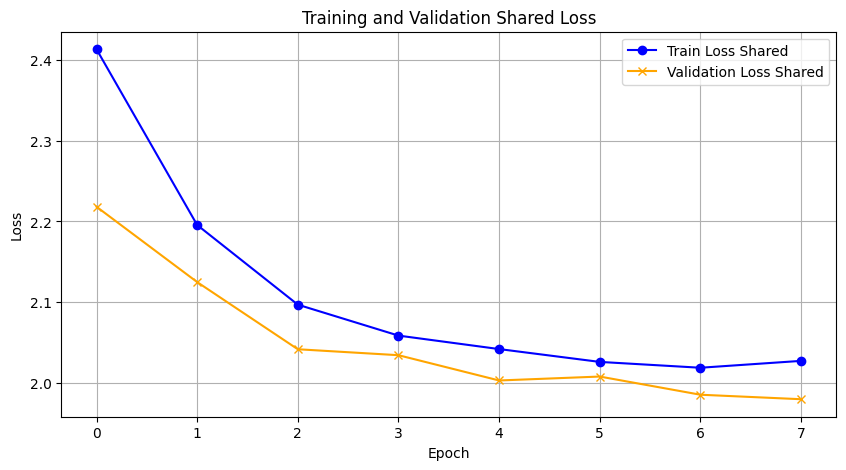

In [ ]:
# Funzione per il plot delle perdite
def plot_shared_losses(train_losses_shared, val_losses_shared, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss Shared', marker='o', color='blue')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss Shared', marker='x', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Shared Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Plot delle perdite
train_losses_shared = train_losses[2]  # Estrai train_losses_shared
val_losses_shared = val_losses[2]      # Estrai val_losses_shared
plot_shared_losses(train_losses_shared, val_losses_shared, num_epochs)


In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    total_correct_fruit = 0
    total_correct_fresh = 0
    total_samples = 0

    all_labels_fruit = []
    all_pred_fruit = []
    all_labels_fresh = []
    all_pred_fresh = []

    with torch.no_grad():
        # Barra di progresso per il testing
        with tqdm(test_loader, desc="Testing", unit="batch") as t:
            for images, labels_fruit, labels_fresh in t:
                images, labels_fruit, labels_fresh = images.to(device), labels_fruit.to(device), labels_fresh.to(device)

                # Forward pass
                fruit_out, fresh_out = model(images)

                # Calcolo delle predizioni
                _, predicted_fruit = torch.max(fruit_out, 1)
                _, predicted_fresh = torch.max(fresh_out, 1)

                # Accuratezza
                total_correct_fruit += (predicted_fruit == labels_fruit).sum().item()
                total_correct_fresh += (predicted_fresh == labels_fresh).sum().item()
                total_samples += labels_fruit.size(0)

                # Accumula le etichette e predizioni
                all_labels_fruit.extend(labels_fruit.cpu().numpy())
                all_pred_fruit.extend(predicted_fruit.cpu().numpy())
                all_labels_fresh.extend(labels_fresh.cpu().numpy())
                all_pred_fresh.extend(predicted_fresh.cpu().numpy())

                # Aggiorna la barra di progresso
                t.set_postfix(fruit_accuracy=100 * total_correct_fruit / total_samples,
                              fresh_accuracy=100 * total_correct_fresh / total_samples)

    print(f"Fruit Classification Accuracy: {100 * total_correct_fruit / total_samples:.2f}%")
    print(f"Freshness Classification Accuracy: {100 * total_correct_fresh / total_samples:.2f}%")
    return all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh

# Chiamata del testing
all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh = test_model(model, test_loader, device)


Testing: 100%|██████████| 307/307 [01:04<00:00,  4.75batch/s, fresh_accuracy=50.8, fruit_accuracy=2.65]

Fruit Classification Accuracy: 2.65%
Freshness Classification Accuracy: 50.82%


In [ ]:
# Funzione per calcolare metriche di valutazione
def compute_metrics(all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh, num_classes_fruit):
    # Metriche per i frutti
    precision_fruit = precision_score(all_labels_fruit, all_pred_fruit, average=None)
    recall_fruit = recall_score(all_labels_fruit, all_pred_fruit, average=None)
    f1_fruit = f1_score(all_labels_fruit, all_pred_fruit, average=None)

    # Metriche per fresh/rotten
    precision_fresh = precision_score(all_labels_fresh, all_pred_fresh, average=None)
    recall_fresh = recall_score(all_labels_fresh, all_pred_fresh, average=None)
    f1_fresh = f1_score(all_labels_fresh, all_pred_fresh, average=None)

    # Valori medi
    precision_fruit_avg = precision_score(all_labels_fruit, all_pred_fruit, average='macro')
    recall_fruit_avg = recall_score(all_labels_fruit, all_pred_fruit, average='macro')
    f1_fruit_avg = f1_score(all_labels_fruit, all_pred_fruit, average='macro')

    precision_fresh_avg = precision_score(all_labels_fresh, all_pred_fresh, average='macro')
    recall_fresh_avg = recall_score(all_labels_fresh, all_pred_fresh, average='macro')
    f1_fresh_avg = f1_score(all_labels_fresh, all_pred_fresh, average='macro')

    # Stampa i risultati
    print("\nFruit Classification Metrics:")
    for i in range(num_classes_fruit):
        print(f"Class {i}: Precision: {precision_fruit[i]:.2f}, Recall: {recall_fruit[i]:.2f}, F1-Score: {f1_fruit[i]:.2f}")
    print(f"Average Fruit Metrics: Precision: {precision_fruit_avg:.2f}, Recall: {recall_fruit_avg:.2f}, F1-Score: {f1_fruit_avg:.2f}")

    print("\nFresh/Rotten Classification Metrics:")
    print(f"Fresh: Precision: {precision_fresh[0]:.2f}, Recall: {recall_fresh[0]:.2f}, F1-Score: {f1_fresh[0]:.2f}")
    print(f"Rotten: Precision: {precision_fresh[1]:.2f}, Recall: {recall_fresh[1]:.2f}, F1-Score: {f1_fresh[1]:.2f}")
    print(f"Average Freshness Metrics: Precision: {precision_fresh_avg:.2f}, Recall: {recall_fresh_avg:.2f}, F1-Score: {f1_fresh_avg:.2f}")

# Chiamata del calcolo metriche
compute_metrics(all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh, num_classes_fruit)



Fruit Classification Metrics:
Class 0: Precision: 0.15, Recall: 1.00, F1-Score: 0.25
Class 1: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 2: Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Class 3: Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Class 4: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 5: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 6: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 7: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 8: Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Average Fruit Metrics: Precision: 0.24, Recall: 0.33, F1-Score: 0.25

Fresh/Rotten Classification Metrics:
Fresh: Precision: 1.00, Recall: 0.16, F1-Score: 0.28
Rotten: Precision: 0.55, Recall: 1.00, F1-Score: 0.71
Average Freshness Metrics: Precision: 0.77, Recall: 0.58, F1-Score: 0.49


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


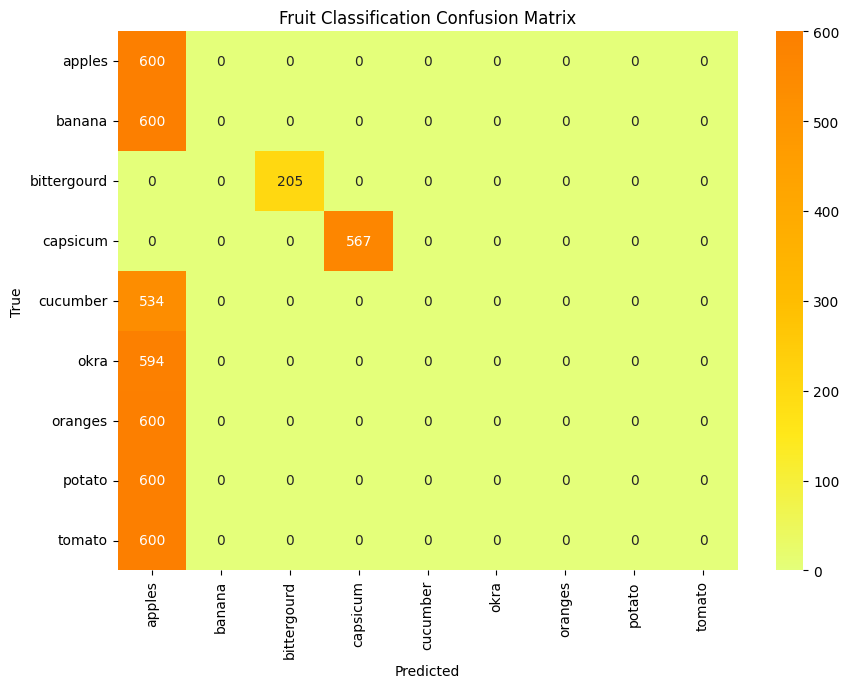

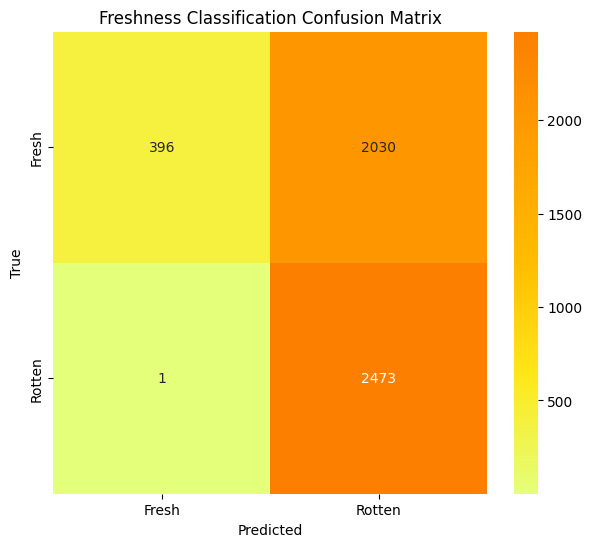

In [ ]:
cmap = "Wistia"

# Matrice di Confusione per la classificazione dei frutti
cm_fruit = confusion_matrix(all_labels_fruit, all_pred_fruit)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_fruit, annot=True, fmt='d', cmap=cmap, xticklabels=['apples', 'banana', 'bittergourd', 'capsicum', 'cucumber', 'okra', 'oranges', 'potato', 'tomato'], yticklabels=['apples', 'banana', 'bittergourd', 'capsicum', 'cucumber', 'okra', 'oranges', 'potato', 'tomato'])
plt.title('Fruit Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Matrice di Confusione per la classificazione della freschezza
cm_fresh = confusion_matrix(all_labels_fresh, all_pred_fresh)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_fresh, annot=True, fmt='d', cmap=cmap, xticklabels=['Fresh', 'Rotten'], yticklabels=['Fresh', 'Rotten'])
plt.title('Freshness Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# RESNET+ MODEL

In [ ]:
class PreTrainedModel(nn.Module):
    def __init__(self,num_classes_fruit, num_classes_fresh):
        super().__init__()
        self.num_classes_fruit = num_classes_fruit
        self.num_classes_fresh = num_classes_fresh

        self.base = torchvision.models.resnet18(weights = False)

        #self.base.classifier = nn.Sequential()
        self.base.fc = nn.Identity()

        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
        )

        self.block2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, self.num_classes_fruit)
        )

        self.block3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, self.num_classes_fresh)
        )

    def forward(self, x):
        # Passaggio attraverso la base (ResNet18)
        x = self.base(x)

        # Passaggio attraverso il primo blocco
        x = self.block1(x)

        # Branch per la classificazione della frutta
        fruit_out = self.block2(x)

        # Branch per la classificazione della freschezza
        fresh_out = self.block3(x)

        return fruit_out, fresh_out


In [ ]:
# Funzione per stampare il numero di parametri allenabili
def count_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Numero di parametri allenabili: {trainable_params}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creazione del modello
ResNetModel = PreTrainedModel(9, 2)
ResNetModel = ResNetModel.to(device)

# # Congelamento dei parametri della parte base (ResNet)
# for param in ResNetModel.base.parameters():
#     param.requires_grad = False

# Stampa il numero di parametri allenabili
count_trainable_parameters(ResNetModel)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.4MB/s]


Numero di parametri allenabili: 11361771


In [ ]:
# Ottimizzatori separati per i rami e il backbone
optimizer_fruit = torch.optim.Adam(ResNetModel.block2.parameters(), lr=0.0001)
optimizer_fresh = torch.optim.Adam(ResNetModel.block3.parameters(), lr=0.0001)
optimizer_shared = torch.optim.Adam([
    {'params': ResNetModel.base.parameters(), 'lr': 1e-5},
    {'params': ResNetModel.block1.parameters(), 'lr': 1e-4}
])

criterion_fruit = nn.CrossEntropyLoss()
criterion_fresh = nn.CrossEntropyLoss()
num_epochs = 8

def train_and_validate(model, train_loader, val_loader, num_epochs, optimizer_fruit, optimizer_fresh,
                      optimizer_shared, criterion_fruit, criterion_fresh, device):
    train_losses_fruit = []
    train_losses_fresh = []
    train_losses_shared = []
    val_losses_fruit = []
    val_losses_fresh = []
    val_losses_shared = []

    for epoch in range(num_epochs):
        model.train()
        running_loss_fruit = 0.0
        running_loss_fresh = 0.0
        running_loss_shared = 0.0

        # Usare tqdm per il loop di training
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for images, labels_fruit, labels_fresh in train_loader:
                images = images.to(device)
                labels_fruit = labels_fruit.to(device)
                labels_fresh = labels_fresh.to(device)

                # Forward pass
                fruit_out, fresh_out = model(images)

                # Calcolo delle perdite separate
                loss_fruit = criterion_fruit(fruit_out, labels_fruit)
                loss_fresh = criterion_fresh(fresh_out, labels_fresh)
                loss_shared = (loss_fruit + loss_fresh) / 2

                # Reset dei gradienti per tutti gli optimizer
                optimizer_shared.zero_grad()
                optimizer_fruit.zero_grad()
                optimizer_fresh.zero_grad()

                # Backward pass combinato
                total_loss = loss_shared + loss_fruit + loss_fresh
                total_loss.backward()

                # Step degli optimizer
                optimizer_shared.step()
                optimizer_fruit.step()
                optimizer_fresh.step()

                running_loss_fruit += loss_fruit.item()
                running_loss_fresh += loss_fresh.item()
                running_loss_shared += loss_shared.item()

                # Aggiornare la barra di progresso
                pbar.set_postfix({
                    "Loss Fruit": f"{loss_fruit.item():.4f}",
                    "Loss Fresh": f"{loss_fresh.item():.4f}",
                    "Loss Shared": f"{loss_shared.item():.4f}"
                })
                pbar.update(1)

        avg_train_loss_fruit = running_loss_fruit / len(train_loader)
        avg_train_loss_fresh = running_loss_fresh / len(train_loader)
        avg_train_loss_shared = running_loss_shared / len(train_loader)
        train_losses_fruit.append(avg_train_loss_fruit)
        train_losses_fresh.append(avg_train_loss_fresh)
        train_losses_shared.append(avg_train_loss_shared)

        # Validazione ogni 2 epoche
        if (epoch + 1) % 2 == 0:
            model.eval()
            val_loss_fruit = 0.0
            val_loss_fresh = 0.0
            val_loss_shared = 0.0

            with torch.no_grad():
                for images, labels_fruit, labels_fresh in val_loader:
                    images = images.to(device)
                    labels_fruit = labels_fruit.to(device)
                    labels_fresh = labels_fresh.to(device)

                    fruit_out, fresh_out = model(images)

                    loss_fruit = criterion_fruit(fruit_out, labels_fruit)
                    loss_fresh = criterion_fresh(fresh_out, labels_fresh)
                    loss_shared = (loss_fruit + loss_fresh) / 2

                    val_loss_fruit += loss_fruit.item()
                    val_loss_fresh += loss_fresh.item()
                    val_loss_shared += loss_shared.item()

            avg_val_loss_fruit = val_loss_fruit / len(val_loader)
            avg_val_loss_fresh = val_loss_fresh / len(val_loader)
            avg_val_loss_shared = val_loss_shared / len(val_loader)
            val_losses_fruit.append(avg_val_loss_fruit)
            val_losses_fresh.append(avg_val_loss_fresh)
            val_losses_shared.append(avg_val_loss_shared)

            print(f"\nEpoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss Fruit: {avg_train_loss_fruit:.4f}, Val Loss Fruit: {avg_val_loss_fruit:.4f}")
            print(f"Train Loss Fresh: {avg_train_loss_fresh:.4f}, Val Loss Fresh: {avg_val_loss_fresh:.4f}")
            print(f"Train Loss Shared: {avg_train_loss_shared:.4f}, Val Loss Shared: {avg_val_loss_shared:.4f}")
        else:
            print(f"\nEpoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss Fruit: {avg_train_loss_fruit:.4f}")
            print(f"Train Loss Fresh: {avg_train_loss_fresh:.4f}")
            print(f"Train Loss Shared: {avg_train_loss_shared:.4f}")

    return (train_losses_fruit, train_losses_fresh, train_losses_shared), \
           (val_losses_fruit, val_losses_fresh, val_losses_shared)

# Chiamata della funzione
train_losses, val_losses = train_and_validate(ResNetModel, train_loader, val_loader, num_epochs, optimizer_fruit, optimizer_fresh, optimizer_shared, criterion_fruit, criterion_fresh, device)# Chiamata della funzione


Epoch 1/8: 100%|██████████| 105/105 [01:03<00:00,  1.65batch/s, Loss Fruit=1.6207, Loss Fresh=0.6996, Loss Shared=1.1601]



Epoch [1/8]
Train Loss Fruit: 1.8394
Train Loss Fresh: 0.6723
Train Loss Shared: 1.2559


Epoch 2/8: 100%|██████████| 105/105 [00:55<00:00,  1.90batch/s, Loss Fruit=0.8784, Loss Fresh=0.5845, Loss Shared=0.7314]



Epoch [2/8]
Train Loss Fruit: 0.9994, Val Loss Fruit: 0.6824
Train Loss Fresh: 0.5951, Val Loss Fresh: 0.5213
Train Loss Shared: 0.7972, Val Loss Shared: 0.6019


Epoch 3/8: 100%|██████████| 105/105 [00:53<00:00,  1.96batch/s, Loss Fruit=0.7770, Loss Fresh=0.4094, Loss Shared=0.5932]



Epoch [3/8]
Train Loss Fruit: 0.7320
Train Loss Fresh: 0.4697
Train Loss Shared: 0.6008


Epoch 4/8: 100%|██████████| 105/105 [00:53<00:00,  1.96batch/s, Loss Fruit=0.5262, Loss Fresh=0.3523, Loss Shared=0.4393]



Epoch [4/8]
Train Loss Fruit: 0.6377, Val Loss Fruit: 0.4751
Train Loss Fresh: 0.3098, Val Loss Fresh: 0.2320
Train Loss Shared: 0.4737, Val Loss Shared: 0.3536


Epoch 5/8: 100%|██████████| 105/105 [00:53<00:00,  1.95batch/s, Loss Fruit=0.4752, Loss Fresh=0.3031, Loss Shared=0.3891]



Epoch [5/8]
Train Loss Fruit: 0.5346
Train Loss Fresh: 0.2411
Train Loss Shared: 0.3878


Epoch 6/8: 100%|██████████| 105/105 [00:53<00:00,  1.95batch/s, Loss Fruit=0.6791, Loss Fresh=0.0952, Loss Shared=0.3872]



Epoch [6/8]
Train Loss Fruit: 0.4491, Val Loss Fruit: 0.3369
Train Loss Fresh: 0.2193, Val Loss Fresh: 0.1757
Train Loss Shared: 0.3342, Val Loss Shared: 0.2563


Epoch 7/8: 100%|██████████| 105/105 [00:53<00:00,  1.95batch/s, Loss Fruit=0.3378, Loss Fresh=0.1342, Loss Shared=0.2360]



Epoch [7/8]
Train Loss Fruit: 0.3691
Train Loss Fresh: 0.1656
Train Loss Shared: 0.2673


Epoch 8/8: 100%|██████████| 105/105 [00:54<00:00,  1.94batch/s, Loss Fruit=0.2914, Loss Fresh=0.1749, Loss Shared=0.2332]



Epoch [8/8]
Train Loss Fruit: 0.2977, Val Loss Fruit: 0.2075
Train Loss Fresh: 0.1430, Val Loss Fresh: 0.1592
Train Loss Shared: 0.2203, Val Loss Shared: 0.1833


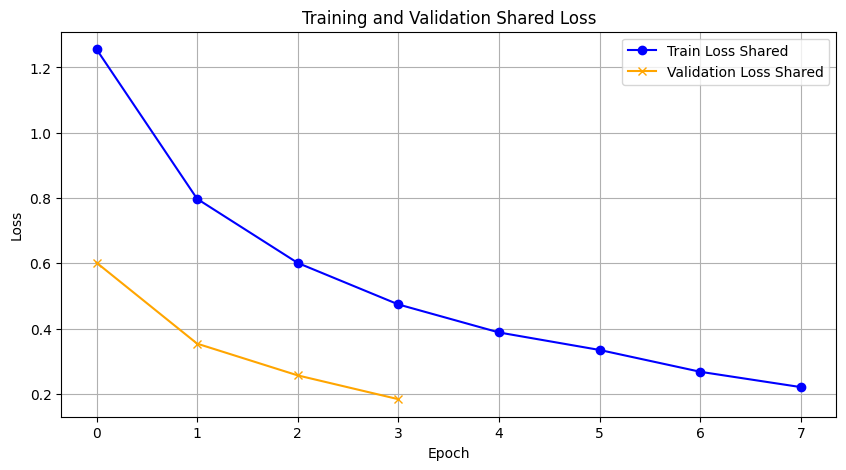

In [ ]:
# Funzione per il plot delle perdite
def plot_shared_losses(train_losses_shared, val_losses_shared, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_losses_shared)), train_losses_shared, label='Train Loss Shared', marker='o', color='blue')
    plt.plot(range(len(val_losses_shared)), val_losses_shared, label='Validation Loss Shared', marker='x', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Shared Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Plot delle perdite
train_losses_shared = train_losses[2]
val_losses_shared = val_losses[2]
plot_shared_losses(train_losses_shared, val_losses_shared, num_epochs)


In [ ]:
# Funzione per il testing del modello
def test_model(model, test_loader, device):
    model.eval()
    total_correct_fruit = 0
    total_correct_fresh = 0
    total_samples = 0

    all_labels_fruit = []
    all_pred_fruit = []
    all_labels_fresh = []
    all_pred_fresh = []

    with torch.no_grad():
        # Barra di progresso per il testing
        with tqdm(test_loader, desc="Testing", unit="batch") as t:
            for images, labels_fruit, labels_fresh in t:
                images, labels_fruit, labels_fresh = images.to(device), labels_fruit.to(device), labels_fresh.to(device)

                # Forward pass
                fruit_out, fresh_out = model(images)

                # Calcolo delle predizioni
                _, predicted_fruit = torch.max(fruit_out, 1)
                _, predicted_fresh = torch.max(fresh_out, 1)

                # Accuratezza
                total_correct_fruit += (predicted_fruit == labels_fruit).sum().item()
                total_correct_fresh += (predicted_fresh == labels_fresh).sum().item()
                total_samples += labels_fruit.size(0)

                # Accumula le etichette e predizioni
                all_labels_fruit.extend(labels_fruit.cpu().numpy())
                all_pred_fruit.extend(predicted_fruit.cpu().numpy())
                all_labels_fresh.extend(labels_fresh.cpu().numpy())
                all_pred_fresh.extend(predicted_fresh.cpu().numpy())

                # Aggiorna la barra di progresso
                t.set_postfix(fruit_accuracy=100 * total_correct_fruit / total_samples,
                              fresh_accuracy=100 * total_correct_fresh / total_samples)

    print(f"Fruit Classification Accuracy: {100 * total_correct_fruit / total_samples:.2f}%")
    print(f"Freshness Classification Accuracy: {100 * total_correct_fresh / total_samples:.2f}%")
    return all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh

# Chiamata del testing
all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh = test_model(ResNetModel, test_loader, device)


Testing: 100%|██████████| 307/307 [00:36<00:00,  8.46batch/s, fresh_accuracy=95.5, fruit_accuracy=92.4]

Fruit Classification Accuracy: 92.39%
Freshness Classification Accuracy: 95.53%


In [ ]:
# Funzione per calcolare metriche di valutazione
def compute_metrics(all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh, num_classes_fruit):
    # Metriche per i frutti
    precision_fruit = precision_score(all_labels_fruit, all_pred_fruit, average=None)
    recall_fruit = recall_score(all_labels_fruit, all_pred_fruit, average=None)
    f1_fruit = f1_score(all_labels_fruit, all_pred_fruit, average=None)

    # Metriche per fresh/rotten
    precision_fresh = precision_score(all_labels_fresh, all_pred_fresh, average=None)
    recall_fresh = recall_score(all_labels_fresh, all_pred_fresh, average=None)
    f1_fresh = f1_score(all_labels_fresh, all_pred_fresh, average=None)

    # Valori medi
    precision_fruit_avg = precision_score(all_labels_fruit, all_pred_fruit, average='macro')
    recall_fruit_avg = recall_score(all_labels_fruit, all_pred_fruit, average='macro')
    f1_fruit_avg = f1_score(all_labels_fruit, all_pred_fruit, average='macro')

    precision_fresh_avg = precision_score(all_labels_fresh, all_pred_fresh, average='macro')
    recall_fresh_avg = recall_score(all_labels_fresh, all_pred_fresh, average='macro')
    f1_fresh_avg = f1_score(all_labels_fresh, all_pred_fresh, average='macro')

    # Stampa i risultati
    print("\nFruit Classification Metrics:")
    for i in range(num_classes_fruit):
        print(f"Class {i}: Precision: {precision_fruit[i]:.2f}, Recall: {recall_fruit[i]:.2f}, F1-Score: {f1_fruit[i]:.2f}")
    print(f"Average Fruit Metrics: Precision: {precision_fruit_avg:.2f}, Recall: {recall_fruit_avg:.2f}, F1-Score: {f1_fruit_avg:.2f}")

    print("\nFresh/Rotten Classification Metrics:")
    print(f"Fresh: Precision: {precision_fresh[0]:.2f}, Recall: {recall_fresh[0]:.2f}, F1-Score: {f1_fresh[0]:.2f}")
    print(f"Rotten: Precision: {precision_fresh[1]:.2f}, Recall: {recall_fresh[1]:.2f}, F1-Score: {f1_fresh[1]:.2f}")
    print(f"Average Freshness Metrics: Precision: {precision_fresh_avg:.2f}, Recall: {recall_fresh_avg:.2f}, F1-Score: {f1_fresh_avg:.2f}")

# Chiamata del calcolo metriche
compute_metrics(all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh, 9)



Fruit Classification Metrics:
Class 0: Precision: 0.83, Recall: 0.96, F1-Score: 0.89
Class 1: Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Class 2: Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Class 3: Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Class 4: Precision: 0.86, Recall: 0.75, F1-Score: 0.80
Class 5: Precision: 0.81, Recall: 0.96, F1-Score: 0.88
Class 6: Precision: 0.94, Recall: 0.79, F1-Score: 0.86
Class 7: Precision: 0.99, Recall: 0.92, F1-Score: 0.95
Class 8: Precision: 1.00, Recall: 0.99, F1-Score: 0.99
Average Fruit Metrics: Precision: 0.93, Recall: 0.93, F1-Score: 0.93

Fresh/Rotten Classification Metrics:
Fresh: Precision: 0.96, Recall: 0.95, F1-Score: 0.95
Rotten: Precision: 0.96, Recall: 0.96, F1-Score: 0.96
Average Freshness Metrics: Precision: 0.96, Recall: 0.96, F1-Score: 0.96


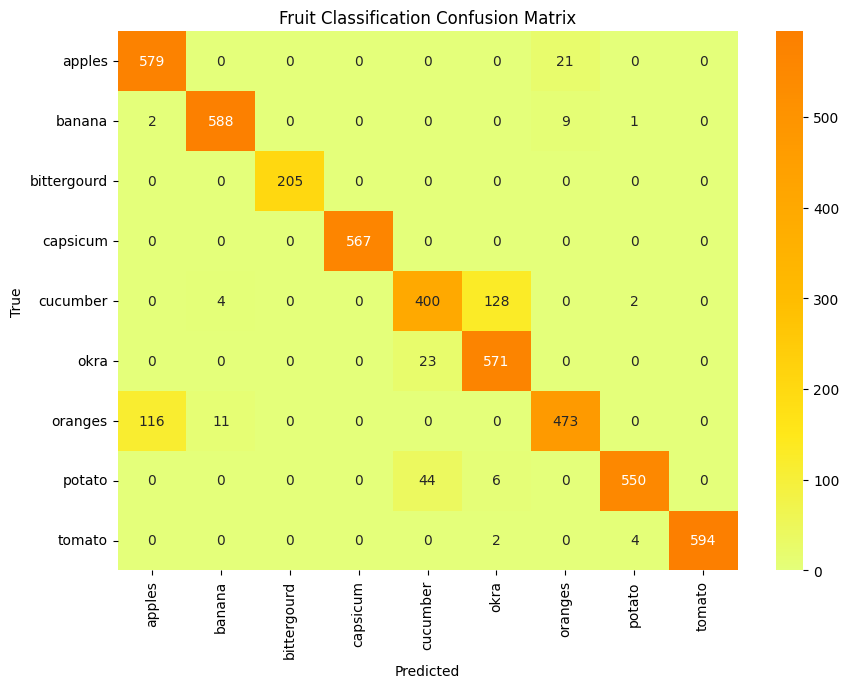

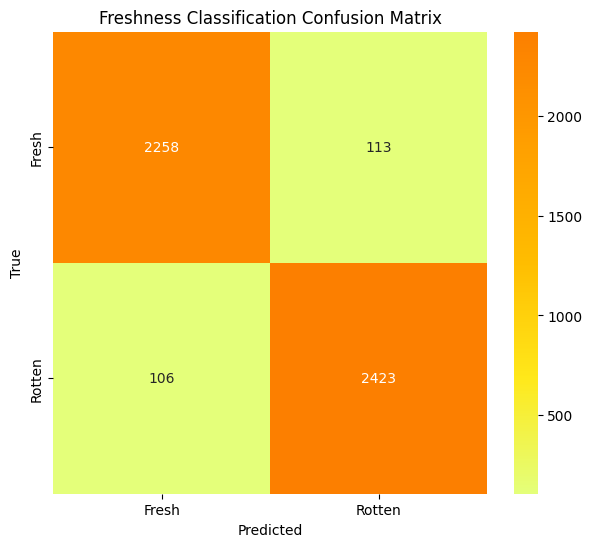

In [ ]:
cmap = "Wistia"

# Matrice di Confusione per la classificazione dei frutti
cm_fruit = confusion_matrix(all_labels_fruit, all_pred_fruit)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_fruit, annot=True, fmt='d', cmap=cmap, xticklabels=['apples', 'banana', 'bittergourd', 'capsicum', 'cucumber', 'okra', 'oranges', 'potato', 'tomato'], yticklabels=['apples', 'banana', 'bittergourd', 'capsicum', 'cucumber', 'okra', 'oranges', 'potato', 'tomato'])
plt.title('Fruit Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Matrice di Confusione per la classificazione della freschezza
cm_fresh = confusion_matrix(all_labels_fresh, all_pred_fresh)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_fresh, annot=True, fmt='d', cmap=cmap, xticklabels=['Fresh', 'Rotten'], yticklabels=['Fresh', 'Rotten'])
plt.title('Freshness Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# save model
torch.save(ResNetModel.state_dict(), '/content/drive/MyDrive/ProgettoIMCS/ResNetModel++.pth')

# XAI

In [ ]:
'''
# Seleziona un'immagine casuale dal dataset
def get_random_image_path(directory):
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    return random.choice(all_files) if all_files else None

dataset_path = '/content/data/dataset/Test/rottenapples'
img_path = get_random_image_path(dataset_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.0, std=1.0)
])

image = Image.open(img_path).convert('RGB')
image = transform(image)
image = image.to(device)

target_class1 = 0
target_class2 = 1
'''

NameError: name 'device' is not defined

In [ ]:
def get_random_test_image():
    # Get random index
    idx = random.randint(0, len(test_dataset) - 1)

    # Get image and labels
    img, fruit_label, fresh_label = test_dataset[idx]

    # Convert tensor to numpy for visualization
    img_np = img.numpy().transpose(1, 2, 0)

    # Denormalize image
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Convert labels to original categories
    fruit_name = label_to_fruit[fruit_label.item()]
    fresh_status = "Fresh" if fresh_label.item() == 0 else "Rotten"

    return img, img_np, fruit_label.item(), fresh_label.item(), fruit_name, fresh_status

def display_test_image():
    img, img_np, fruit_label, fresh_label, fruit_name, fresh_status = get_random_test_image()
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title(f"Fruit: {fruit_name}\nStatus: {fresh_status}\nLabels: (Fruit: {fruit_label}, Fresh: {fresh_label})")
    plt.axis('off')
    plt.show()

    return img, fruit_label, fresh_label

Mounted at /content/drive


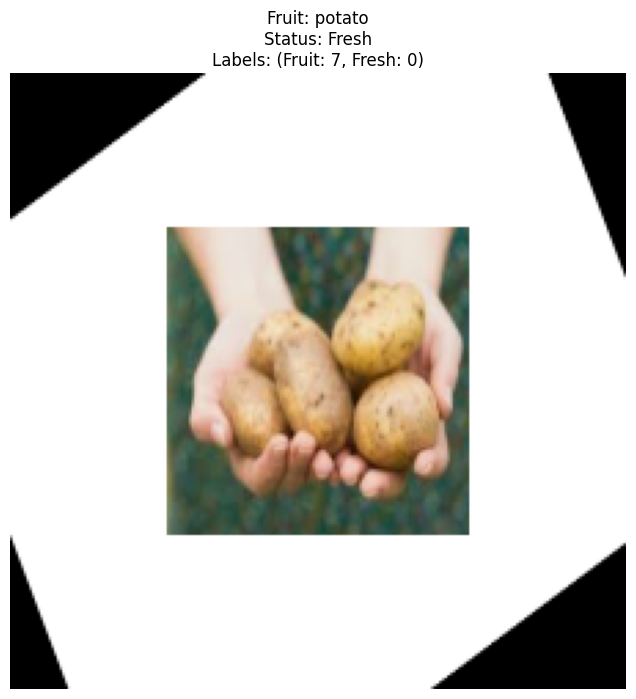

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Get random test image with labels
image, target_class1, target_class2 = display_test_image()


## XAI CNN

In [ ]:
device = 'cpu'

In [ ]:
class CAMDualTaskCNN(DualTaskCNN):
    def __init__(self, num_classes_fruit, num_classes_fresh):
        super().__init__(num_classes_fruit, num_classes_fresh)

    def get_cam(self, x, task='fruit'):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        features = F.relu(self.conv3(x))
        x = self.pool(features)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        if task == 'fruit':
            weights = self.fc_fruit.weight
        else:
            weights = self.fc_fresh.weight

        return features, weights

def generate_cam(model, image, target_class, task='fruit', device='cpu'):
    model.eval()

    if isinstance(image, np.ndarray):
        image = transforms.ToTensor()(Image.fromarray(image))
    if image.dim() == 3:
        image = image.unsqueeze(0)

    image = image.to(device)
    features, weights = model.get_cam(image, task)

    batch_size, num_channels, h, w = features.shape
    class_weights = weights[target_class]

    cam = torch.zeros((h, w), device=device)
    for i, w in enumerate(class_weights):
        cam += w * features[0, i, :, :]

    cam = F.relu(cam)
    cam = cam - torch.min(cam)
    cam = cam / torch.max(cam)

    return cam.cpu().detach().numpy()

def visualize_cam(model, image, target_class, task='fruit', device='cpu', title=None):
    cam = generate_cam(model, image, target_class, task, device)

    if torch.is_tensor(image):
        if image.dim() == 4:
            image = image[0]
        image = image.cpu().numpy().transpose(1, 2, 0)

    image = (image - image.min()) / (image.max() - image.min())
    cam_resized = np.array(Image.fromarray(cam).resize((image.shape[1], image.shape[0]), Image.BICUBIC))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam_resized, cmap='jet')
    plt.title(f'CAM ({task.capitalize()} Task)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    heatmap = plt.cm.jet(cam_resized)[:, :, :3]
    overlay = image * 0.7 + heatmap * 0.3
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')

    if title:
        plt.suptitle(title)
    plt.tight_layout()



    plt.show()


In [ ]:
# Carica il modello pre-addestrato
CNN_path =  '/content/drive/MyDrive/ProgettoIMCS/CNN.pth'
CNN = DualTaskCNN(9, 2)
CNN.load_state_dict(torch.load(CNN_path, map_location=torch.device(device)))

# Convert existing model to CAM model
cam_model_CNN = CAMDualTaskCNN(9, 2)
cam_model_CNN.load_state_dict(CNN.state_dict())
cam_model_CNN = cam_model_CNN.to(device)

<ipython-input-32-f3f6a1892d23>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN.load_state_dict(torch.load(CNN_path, map_location=torch.device(device)))


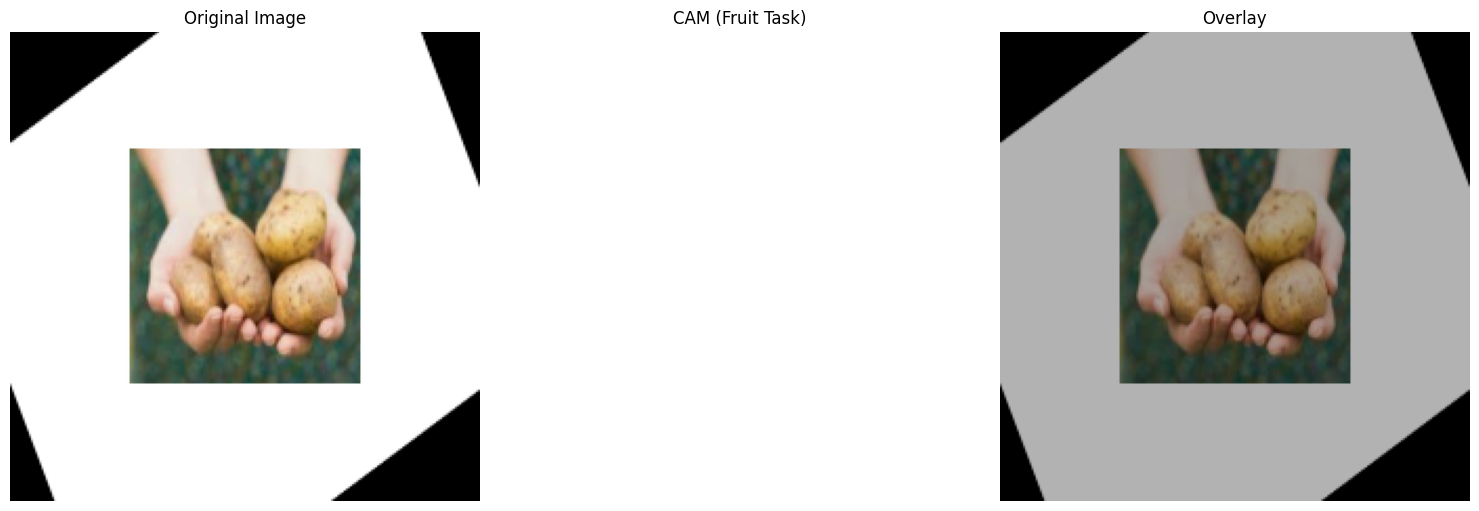

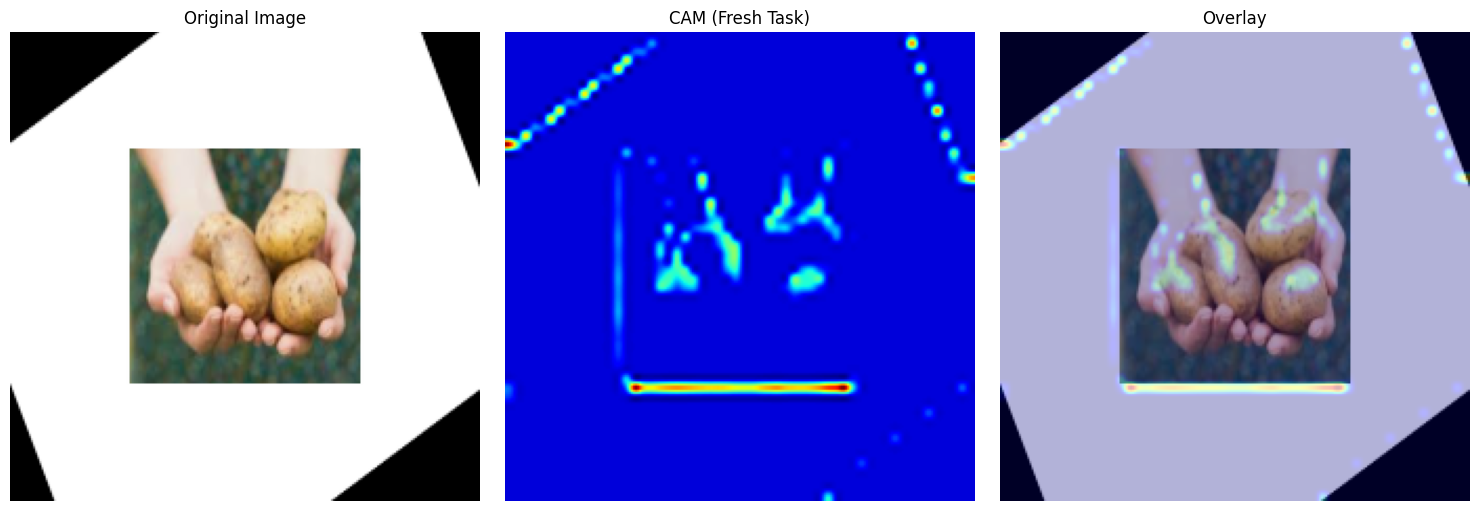

In [ ]:
visualize_cam(cam_model_CNN, image, target_class1, task='fruit')
visualize_cam(cam_model_CNN, image, target_class2, task='fresh')

In [ ]:
res_CNN = CNN(image.unsqueeze(0))

fruit = torch.argmax(res_CNN[0])
fresh = torch.argmax(res_CNN[1])

print(fruit, fresh)

tensor(7) tensor(1)


## XAI RESNET

In [ ]:
class CAMPreTrainedModel(PreTrainedModel):
    def __init__(self, num_classes_fruit, num_classes_fresh):
        super().__init__(num_classes_fruit, num_classes_fresh)

    def get_cam(self, x, task='fruit'):
        # Get the final convolutional layer features from ResNet
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        features = self.base.layer4(x)

        # Global average pooling
        x = self.base.avgpool(features)
        x = torch.flatten(x, 1)

        # Get embeddings through shared layers
        x = self.block1(x)

        # Get weights from the final layer based on task
        if task == 'fruit':
            weights = self.block2[-1].weight
        else:
            weights = self.block3[-1].weight

        return features, weights

def generate_cam(model, image, target_class, task='fruit', device='cpu'):
    model.eval()

    # Preprocess image
    if isinstance(image, np.ndarray):
        image = transforms.ToTensor()(Image.fromarray(image))
    if image.dim() == 3:
        image = image.unsqueeze(0)

    image = image.to(device)

    # Get features and weights
    features, weights = model.get_cam(image, task)

    # Generate CAM
    batch_size, num_channels, h, w = features.shape

    # Get weights for target class
    class_weights = weights[target_class]

    # Compute weighted sum of feature maps
    cam = torch.zeros((h, w), device=device)
    for i, w in enumerate(class_weights):
        cam += w * features[0, i, :, :]

    # Apply ReLU and normalize
    cam = F.relu(cam)
    cam = cam - torch.min(cam)
    cam = cam / torch.max(cam)

    return cam.cpu().detach().numpy()

def visualize_cam(model, image, target_class, task='fruit', device='cpu', title=None):
    # Generate CAM
    cam = generate_cam(model, image, target_class, task, device)

    # Convert image to numpy if it's a tensor
    if torch.is_tensor(image):
        if image.dim() == 4:
            image = image[0]
        image = image.cpu().numpy().transpose(1, 2, 0)

    # Normalize image
    image = (image - image.min()) / (image.max() - image.min())

    # Resize CAM to match image dimensions
    cam_resized = np.array(Image.fromarray(cam).resize((image.shape[1], image.shape[0]), Image.BICUBIC))

    # Create visualization
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam_resized, cmap='jet')
    plt.title(f'CAM ({task.capitalize()} Task)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    heatmap = plt.cm.jet(cam_resized)[:, :, :3]  # Remove alpha channel
    overlay = image * 0.7 + heatmap * 0.3  # Blend original image with heatmap
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')

    if title:
        plt.suptitle(title)
    plt.tight_layout()

    plt.show()


In [ ]:
# Carica il modello pre-addestrato
resnet_path = '/content/drive/MyDrive/ProgettoIMCS/ResNetModel++.pth'
resnet = PreTrainedModel(9, 2)
resnet.load_state_dict(torch.load(resnet_path, map_location=torch.device(device), weights_only=False))

# Convert existing model to CAM model
cam_model_resnet = CAMPreTrainedModel(9, 2)
cam_model_resnet.load_state_dict(resnet.state_dict())
cam_model_resnet = cam_model_resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


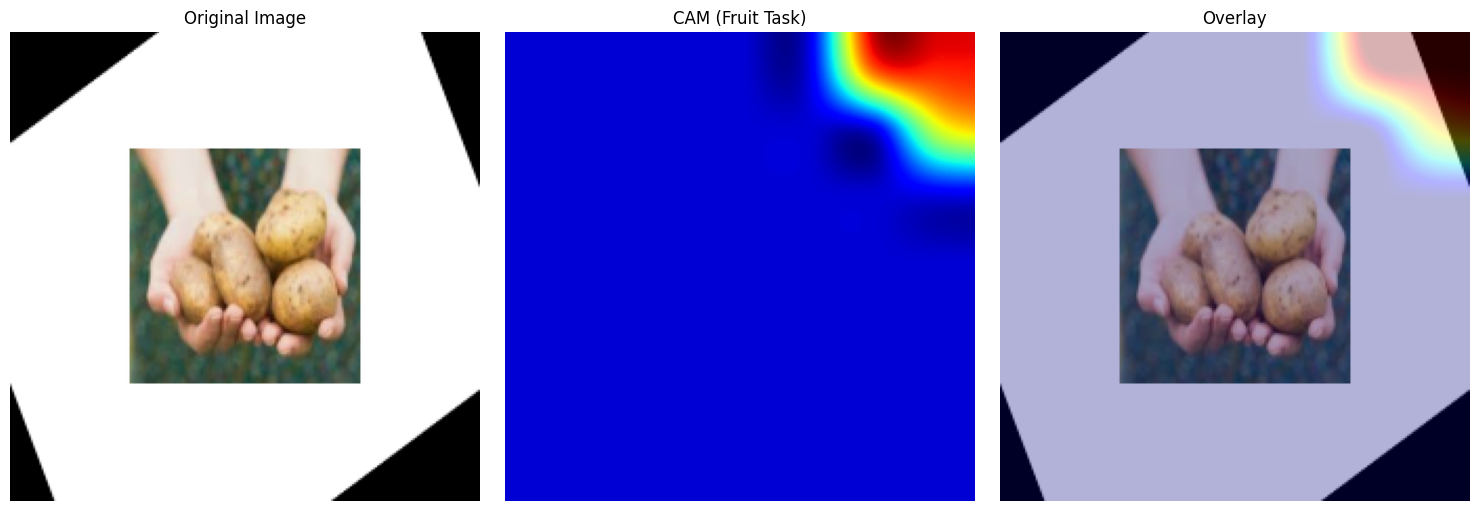

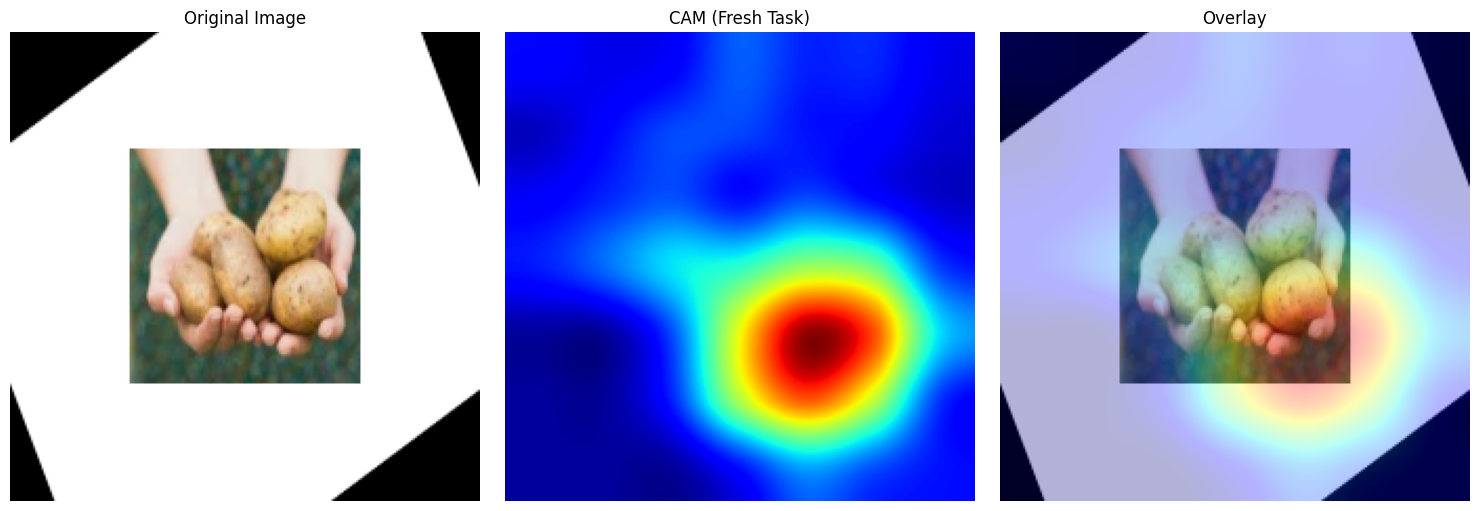

In [ ]:
visualize_cam(cam_model_resnet, image, target_class1, task='fruit')
visualize_cam(cam_model_resnet, image, target_class2, task='fresh')

In [ ]:
res_resnet = resnet(image.unsqueeze(0))

fruit = torch.argmax(res_resnet[0])
fresh = torch.argmax(res_resnet[1])

print(fruit, fresh)

tensor(0) tensor(1)


## XAI RESNET 30%

In [ ]:
# Carica il modello pre-addestrato
resnet30_path = '/content/drive/MyDrive/ProgettoIMCS/PrunedModel30Perc.pth'
resnet30 = PreTrainedModel(9, 2)
resnet30.load_state_dict(torch.load(resnet30_path, map_location=torch.device(device), weights_only=False))

# Convert existing model to CAM model
cam_model_resnet30 = CAMPreTrainedModel(9, 2)
cam_model_resnet30.load_state_dict(resnet30.state_dict())
cam_model_resnet30 = cam_model_resnet30.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


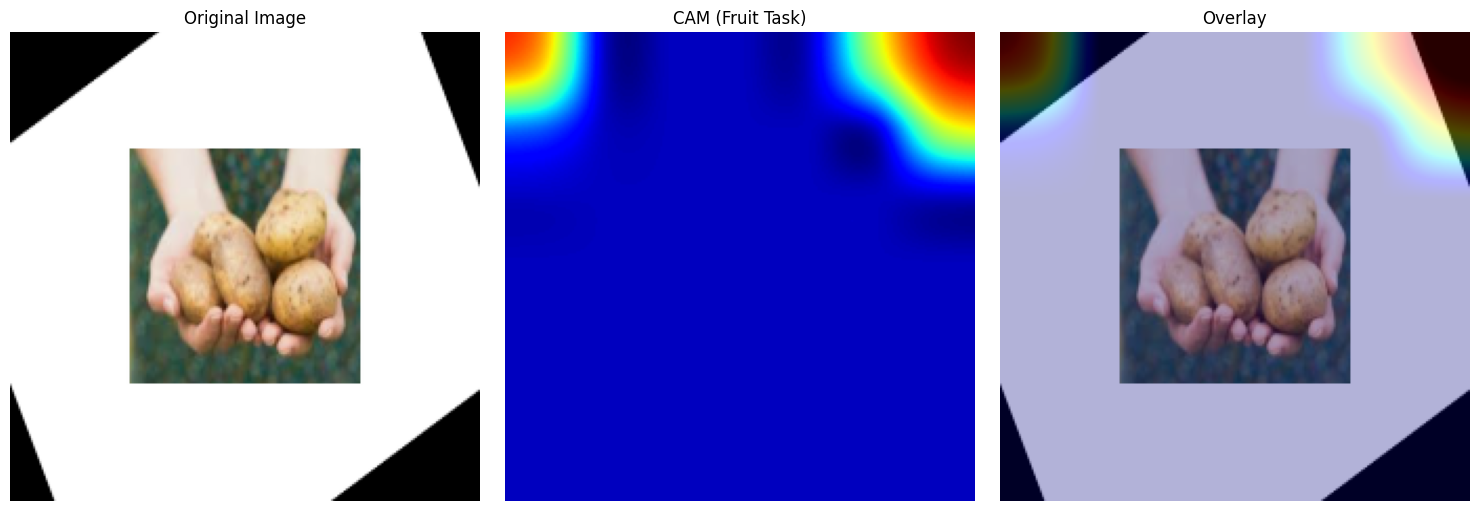

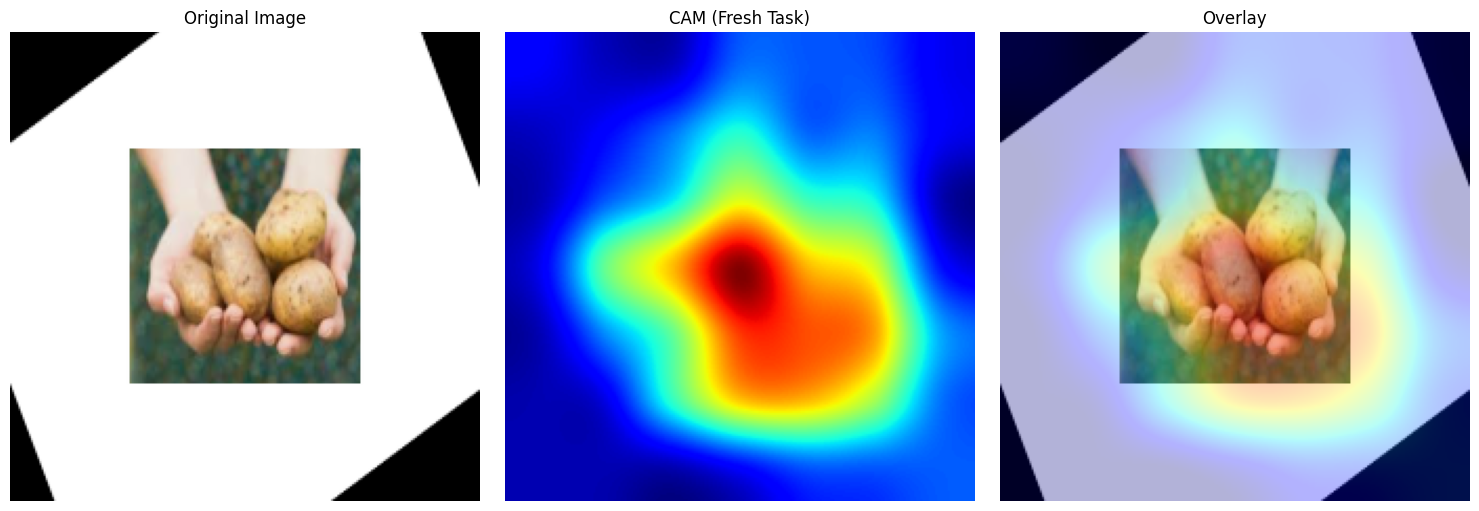

In [ ]:
visualize_cam(cam_model_resnet30, image, target_class1, task='fruit')
visualize_cam(cam_model_resnet30, image, target_class2, task='fresh')

In [ ]:
res_resnet30 = resnet30(image.unsqueeze(0))

fruit = torch.argmax(res_resnet30[0])
fresh = torch.argmax(res_resnet30[1])

print(fruit, fresh)

tensor(0) tensor(1)


## XAI RESNET 50%

In [ ]:
# Carica il modello pre-addestrato
resnet50_path = '/content/drive/MyDrive/ProgettoIMCS/PrunedModel50Perc.pth'
resnet50 = PreTrainedModel(9, 2)
resnet50.load_state_dict(torch.load(resnet50_path, map_location=torch.device(device)))

# Convert existing model to CAM model
cam_model_resnet50 = CAMPreTrainedModel(9, 2)
cam_model_resnet50.load_state_dict(resnet50.state_dict())
cam_model_resnet50 = cam_model_resnet50.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-41-6de9cccee0d2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via th

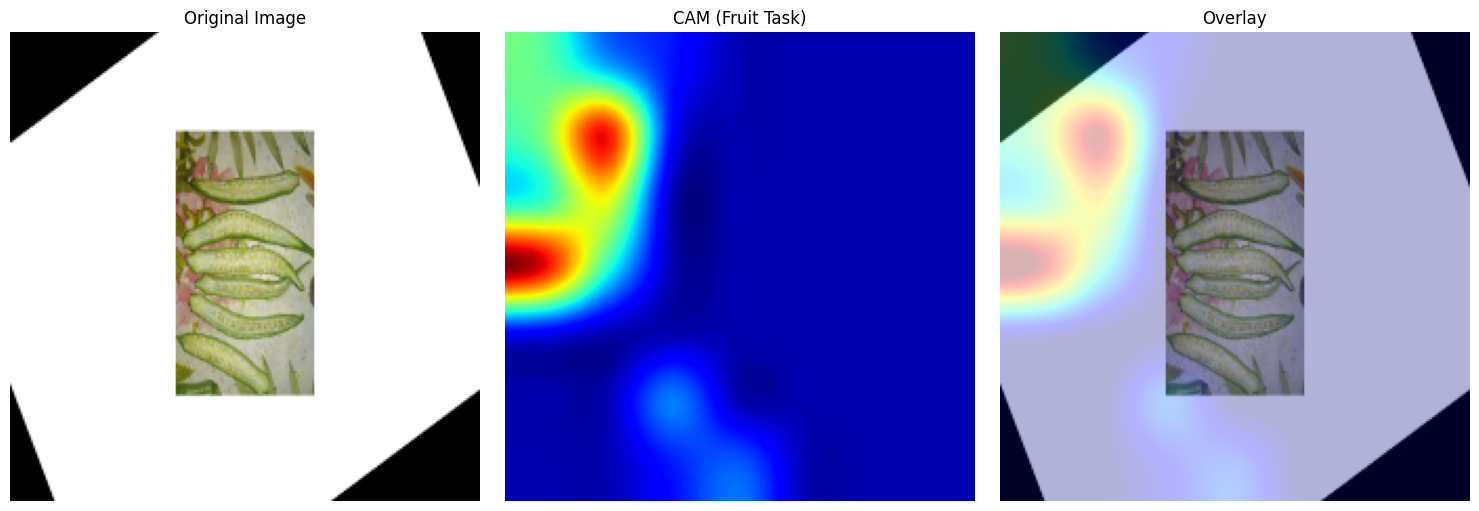

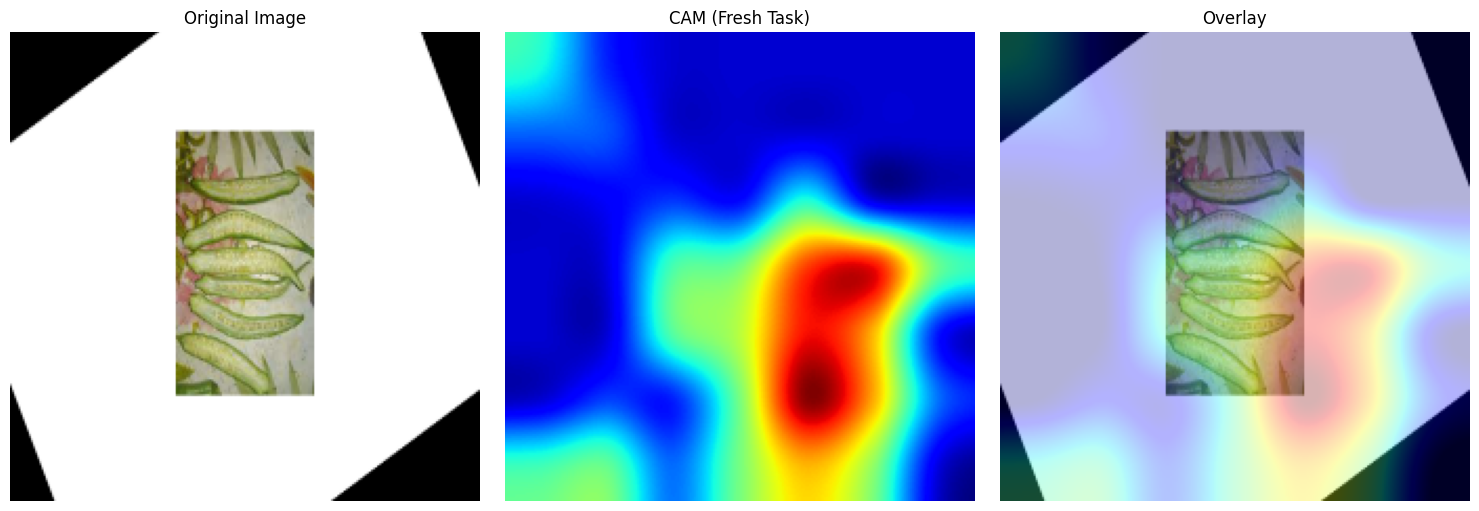

In [ ]:
visualize_cam(cam_model_resnet50, image, target_class1, task='fruit')
visualize_cam(cam_model_resnet50, image, target_class2, task='fresh')

In [ ]:
res_resnet50 = resnet50(image.unsqueeze(0))

fruit = torch.argmax(res_resnet50[0])
fresh = torch.argmax(res_resnet50[1])

print(fruit, fresh)

tensor(8) tensor(1)


## XAI RESNET 70%

In [ ]:
# Carica il modello pre-addestrato
resnet70_path = '/content/drive/MyDrive/ProgettoIMCS/PrunedModel70Perc.pth'
resnet70 = PreTrainedModel(9, 2)
resnet70.load_state_dict(torch.load(resnet70_path, map_location=torch.device(device)))

# Convert existing model to CAM model
cam_model_resnet70 = CAMPreTrainedModel(9, 2)
cam_model_resnet70.load_state_dict(resnet70.state_dict())
cam_model_resnet70 = cam_model_resnet70.to(device)

<ipython-input-45-5386af65383f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet70.load_state_dict(torch.load(resnet70_path, map_location=torch.device(device)))


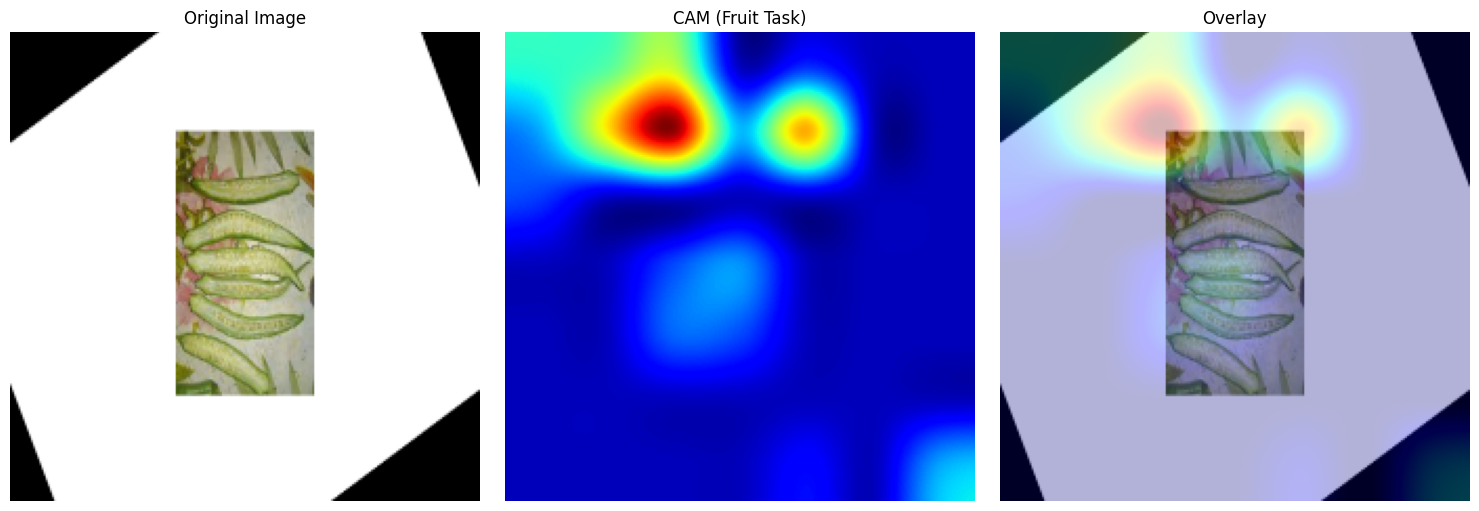

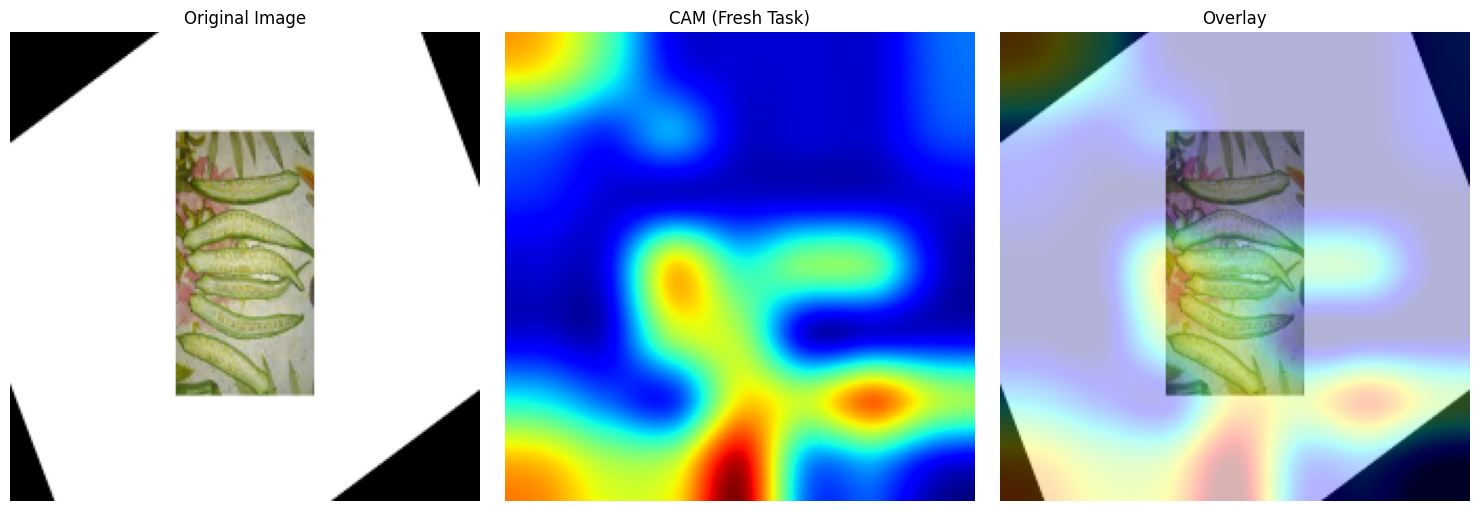

In [ ]:
visualize_cam(cam_model_resnet70, image, target_class1, task='fruit')
visualize_cam(cam_model_resnet70, image, target_class2, task='fresh')

In [ ]:
res_resnet70 = resnet70(image.unsqueeze(0))

fruit = torch.argmax(res_resnet70[0])
fresh = torch.argmax(res_resnet70[1])

print(fruit, fresh)

tensor(1) tensor(1)


# TESTS

In [ ]:
# Funzione per il testing del modello
def test_model(model, test_loader, device):
    model.eval()
    model.to(device)
    total_correct_fruit = 0
    total_correct_fresh = 0
    total_samples = 0

    all_labels_fruit = []
    all_pred_fruit = []
    all_labels_fresh = []
    all_pred_fresh = []

    with torch.no_grad():
        # Barra di progresso per il testing
        with tqdm(test_loader, desc="Testing", unit="batch") as t:
            for images, labels_fruit, labels_fresh in t:
                images, labels_fruit, labels_fresh = images.to(device), labels_fruit.to(device), labels_fresh.to(device)

                # Forward pass
                fruit_out, fresh_out = model(images)

                # Calcolo delle predizioni
                _, predicted_fruit = torch.max(fruit_out, 1)
                _, predicted_fresh = torch.max(fresh_out, 1)

                # Accuratezza
                total_correct_fruit += (predicted_fruit == labels_fruit).sum().item()
                total_correct_fresh += (predicted_fresh == labels_fresh).sum().item()
                total_samples += labels_fruit.size(0)

                # Accumula le etichette e predizioni
                all_labels_fruit.extend(labels_fruit.cpu().numpy())
                all_pred_fruit.extend(predicted_fruit.cpu().numpy())
                all_labels_fresh.extend(labels_fresh.cpu().numpy())
                all_pred_fresh.extend(predicted_fresh.cpu().numpy())

                # Aggiorna la barra di progresso
                t.set_postfix(fruit_accuracy=100 * total_correct_fruit / total_samples,
                              fresh_accuracy=100 * total_correct_fresh / total_samples)

    print()
    print(f"Fruit Classification Accuracy: {100 * total_correct_fruit / total_samples:.2f}%")
    print(f"Freshness Classification Accuracy: {100 * total_correct_fresh / total_samples:.2f}%")
    print()

    return all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh

# Funzione per calcolare metriche di valutazione
def compute_metrics(all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh, num_classes_fruit):
    # Metriche per i frutti
    precision_fruit = precision_score(all_labels_fruit, all_pred_fruit, average=None)
    recall_fruit = recall_score(all_labels_fruit, all_pred_fruit, average=None)
    f1_fruit = f1_score(all_labels_fruit, all_pred_fruit, average=None)

    # Metriche per fresh/rotten
    precision_fresh = precision_score(all_labels_fresh, all_pred_fresh, average=None)
    recall_fresh = recall_score(all_labels_fresh, all_pred_fresh, average=None)
    f1_fresh = f1_score(all_labels_fresh, all_pred_fresh, average=None)

    # Valori medi
    precision_fruit_avg = precision_score(all_labels_fruit, all_pred_fruit, average='macro')
    recall_fruit_avg = recall_score(all_labels_fruit, all_pred_fruit, average='macro')
    f1_fruit_avg = f1_score(all_labels_fruit, all_pred_fruit, average='macro')

    precision_fresh_avg = precision_score(all_labels_fresh, all_pred_fresh, average='macro')
    recall_fresh_avg = recall_score(all_labels_fresh, all_pred_fresh, average='macro')
    f1_fresh_avg = f1_score(all_labels_fresh, all_pred_fresh, average='macro')

    # Stampa i risultati
    print("\nFruit Classification Metrics:")
    for i in range(num_classes_fruit):
        print(f"Class {i}: Precision: {precision_fruit[i]:.2f}, Recall: {recall_fruit[i]:.2f}, F1-Score: {f1_fruit[i]:.2f}")
    print(f"Average Fruit Metrics: Precision: {precision_fruit_avg:.2f}, Recall: {recall_fruit_avg:.2f}, F1-Score: {f1_fruit_avg:.2f}")

    print("\nFresh/Rotten Classification Metrics:")
    print(f"Fresh: Precision: {precision_fresh[0]:.2f}, Recall: {recall_fresh[0]:.2f}, F1-Score: {f1_fresh[0]:.2f}")
    print(f"Rotten: Precision: {precision_fresh[1]:.2f}, Recall: {recall_fresh[1]:.2f}, F1-Score: {f1_fresh[1]:.2f}")
    print(f"Average Freshness Metrics: Precision: {precision_fresh_avg:.2f}, Recall: {recall_fresh_avg:.2f}, F1-Score: {f1_fresh_avg:.2f}")



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Chiamata del testing
#all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh = test_model(CNN, test_loader, device)
all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh = test_model(resnet, test_loader, device)
#all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh = test_model(resnet30, test_loader, device)
#all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh = test_model(resnet50, test_loader, device)
#all_labels_fruit, all_pred_fruit, all_labels_fresh, all_pred_fresh = test_model(resnet70, test_loader, device)


Testing: 100%|██████████| 307/307 [00:35<00:00,  8.71batch/s, fresh_accuracy=77.7, fruit_accuracy=67.8]


Fruit Classification Accuracy: 67.84%
Freshness Classification Accuracy: 77.65%

